# ML-формулировка задачи

**Бизнес-контекст.**  
У нас есть база клиентов компании (ритейл / e-commerce): доход, семья, траты по категориям, каналы покупок, история кампаний.  
Поле `Response` показывает, откликнулся ли клиент на последнюю маркетинговую кампанию  
(`1` — принял предложение, `0` — не принял).

**Цель продукта.**  
Нужно заранее оценивать, **какие клиенты с большей вероятностью откликнутся на скидку/акцию**, чтобы:
- отправлять промо тем, у кого высокая вероятность отклика,
- не раздавать скидки всем подряд и не «сжигать» маркетинговый бюджет.

**ML-задача.**

- Объекты: клиенты.
- Признаки: демография, доход, траты по категориям, покупки по каналам и т.д.
- Целевая переменная: `Response` (0/1).
- Тип задачи: **бинарная классификация** — предсказать, откликнется клиент на кампанию или нет.


## Почему выбираем именно F1 и ROC-AUC

В данных доля откликнувшихся клиентов (`Response = 1`) заметно меньше, чем неоткликнувшихся.  
То есть классы **несбалансированы**, и простая точность (`accuracy`) будет малоинформативна:
модель может почти всегда предсказывать «0» и всё равно получать высокую точность.

Для нашей задачи важны два аспекта:

1. **Качество нахождения откликнувшихся клиентов.**  
   Если мы будем слишком широко рассылать скидки, вырастет число *ложноположительных* срабатываний  
   (скидка ушла, а клиент не купил). Если наоборот — слишком мало, вырастут *ложноотрицательные*  
   (клиент купил бы со скидкой, но мы ему её не дали).  
   Поэтому используем **F1-меру**, которая балансирует **precision** и **recall** по классу `1`  
   и показывает, насколько хорошо мы в целом выделяем тех, кто действительно откликнется.

2. **Качество ранжирования клиентов по вероятности отклика.**  
   В продукте мы не всегда будем выбирать жёсткий порог 0.5 — часто нужно отсортировать клиентов  
   по вероятности отклика и взять, например, топ-N для рассылки.  
   Для этого важна способность модели правильно **ранжировать** объекты.  
   Эту способность хорошо измеряет **ROC-AUC**: чем выше ROC-AUC, тем лучше модель отделяет  
   откликнувшихся клиентов от неоткликнувшихся на всём диапазоне порогов.

Таким образом:

- **F1** отражает, насколько аккуратно модель выделяет целевой класс с точки зрения  
  ошибок первого и второго рода (полезно маркетологу, чтобы не «сливать» скидки).
- **ROC-AUC** отражает качество **скоринга/ранжирования** клиентов (полезно, когда мы выбираем топ-N клиентов с максимальными скоринговыми баллами).

Для удобства сравнения моделей вводим **совокупную метрику** как среднее F1 и ROC-AUC:

score = 0.5 * F1 + 0.5 * ROC_AUC


Эта метрика учитывает и качество классификации, и качество ранжирования.


In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("data/marketing_campaign.csv", sep=',')

df.head()


,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,marital_Together,marital_Widow,education_2n Cycle,education_Basic,education_Graduation,education_Master,education_PhD,MntTotal,MntRegularProds,AcceptedCmpOverall
0,58138.0,0,0,58,635,88,546,172,88,88,...,0,0,0,0,1,0,0,1529,1441,0
1,46344.0,1,1,38,11,1,6,2,1,6,...,0,0,0,0,1,0,0,21,15,0
2,71613.0,0,0,26,426,49,127,111,21,42,...,1,0,0,0,1,0,0,734,692,0
3,26646.0,1,0,26,11,4,20,10,3,5,...,1,0,0,0,1,0,0,48,43,0
4,58293.0,1,0,94,173,43,118,46,27,15,...,0,0,0,0,0,0,1,407,392,0


In [103]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Income                2205 non-null   float64
 1   Kidhome               2205 non-null   int64  
 2   Teenhome              2205 non-null   int64  
 3   Recency               2205 non-null   int64  
 4   MntWines              2205 non-null   int64  
 5   MntFruits             2205 non-null   int64  
 6   MntMeatProducts       2205 non-null   int64  
 7   MntFishProducts       2205 non-null   int64  
 8   MntSweetProducts      2205 non-null   int64  
 9   MntGoldProds          2205 non-null   int64  
 10  NumDealsPurchases     2205 non-null   int64  
 11  NumWebPurchases       2205 non-null   int64  
 12  NumCatalogPurchases   2205 non-null   int64  
 13  NumStorePurchases     2205 non-null   int64  
 14  NumWebVisitsMonth     2205 non-null   int64  
 15  AcceptedCmp3         

Income                  0
Kidhome                 0
Teenhome                0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
Age                     0
Customer_Days           0
marital_Divorced        0
marital_Married         0
marital_Single          0
marital_Together        0
marital_Widow           0
education_2n Cycle      0
education_Basic         0
education_Graduation    0
education_Master        0
education_PhD           0
MntTotal                0
MntRegularProds         0
AcceptedCmpO

## Очистка данных

1. Убираем строки с пропуском в `Income`.
2. Лёгко обрезаем хвосты дохода (`Income`) по 1-му и 99-му перцентилю, чтобы уменьшить влияние экстремальных значений.
3. Удаляем заведомо константные/технические столбцы (`Z_CostContact`, `Z_Revenue`), если они присутствуют.
4. На всякий случай убираем любые колонки, в которых всего одно уникальное значение.



In [104]:
df.columns


Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Days', 'marital_Divorced', 'marital_Married',
       'marital_Single', 'marital_Together', 'marital_Widow',
       'education_2n Cycle', 'education_Basic', 'education_Graduation',
       'education_Master', 'education_PhD', 'MntTotal', 'MntRegularProds',
       'AcceptedCmpOverall'],
      dtype='object')

In [105]:
# 1. Пропуски в доходе
if 'Income' in df.columns:
    print("Пропусков в Income до очистки:", df['Income'].isna().sum())
    df = df[df['Income'].notna()].copy()

    # 2. Обрезка хвостов по квантилям
    low, high = df['Income'].quantile([0.01, 0.99])
    df['Income'] = df['Income'].clip(lower=low, upper=high)

# 3. Удаление технических/константных колонок, если есть
for col in ['Z_CostContact', 'Z_Revenue']:
    if col in df.columns:
        print(f"Дропаем колонку {col}")
        df = df.drop(columns=[col])

# 4. Убираем любые константные признаки
const_cols = [c for c in df.columns if df[c].nunique() <= 1]
if const_cols:
    print("Константные колонки:", const_cols)
    df = df.drop(columns=const_cols)

df.shape



Пропусков в Income до очистки: 0
Дропаем колонку Z_CostContact
Дропаем колонку Z_Revenue


(2205, 37)

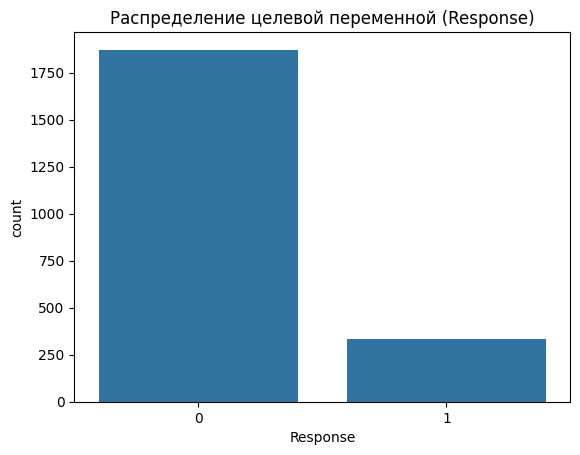

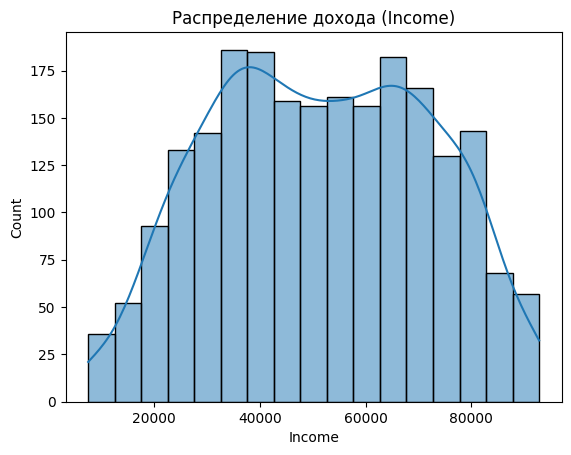

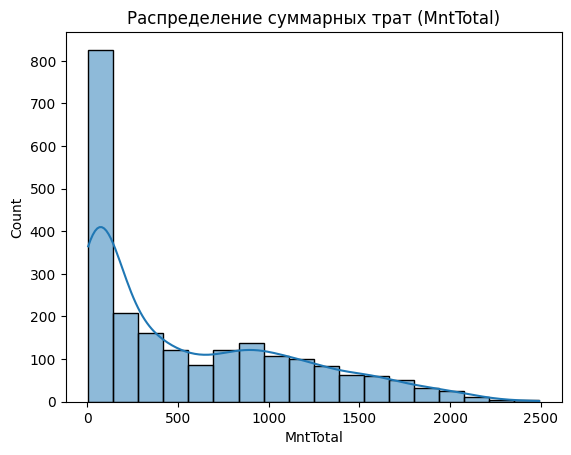

In [106]:
# Распределение целевой переменной
sns.countplot(x='Response', data=df)
plt.title('Распределение целевой переменной (Response)')
plt.show()

# Распределение дохода
sns.histplot(df['Income'], kde=True)
plt.title('Распределение дохода (Income)')
plt.show()

# Суммарные траты уже есть как MntTotal
if 'MntTotal' in df.columns:
    sns.histplot(df['MntTotal'], kde=True)
    plt.title('Распределение суммарных трат (MntTotal)')
    plt.show()


In [107]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

corr_with_target = df[numeric_cols].corr()['Response'].sort_values(ascending=False)
corr_with_target.head(37)


Response                1.000000
AcceptedCmpOverall      0.426961
AcceptedCmp5            0.324648
AcceptedCmp1            0.296978
MntTotal                0.264895
MntRegularProds         0.262363
AcceptedCmp3            0.253576
MntMeatProducts         0.248821
MntWines                0.245559
NumCatalogPurchases     0.234524
Customer_Days           0.196520
AcceptedCmp4            0.179727
Income                  0.172763
AcceptedCmp2            0.169128
NumWebPurchases         0.149699
MntGoldProds            0.140210
MntFruits               0.122331
MntSweetProducts        0.115326
marital_Single          0.113703
MntFishProducts         0.107405
education_PhD           0.089627
marital_Divorced        0.054967
marital_Widow           0.045285
NumStorePurchases       0.033509
NumDealsPurchases       0.004691
education_Master        0.003509
Complain               -0.000273
NumWebVisitsMonth      -0.005358
Age                    -0.021305
education_2n Cycle     -0.035008
education_

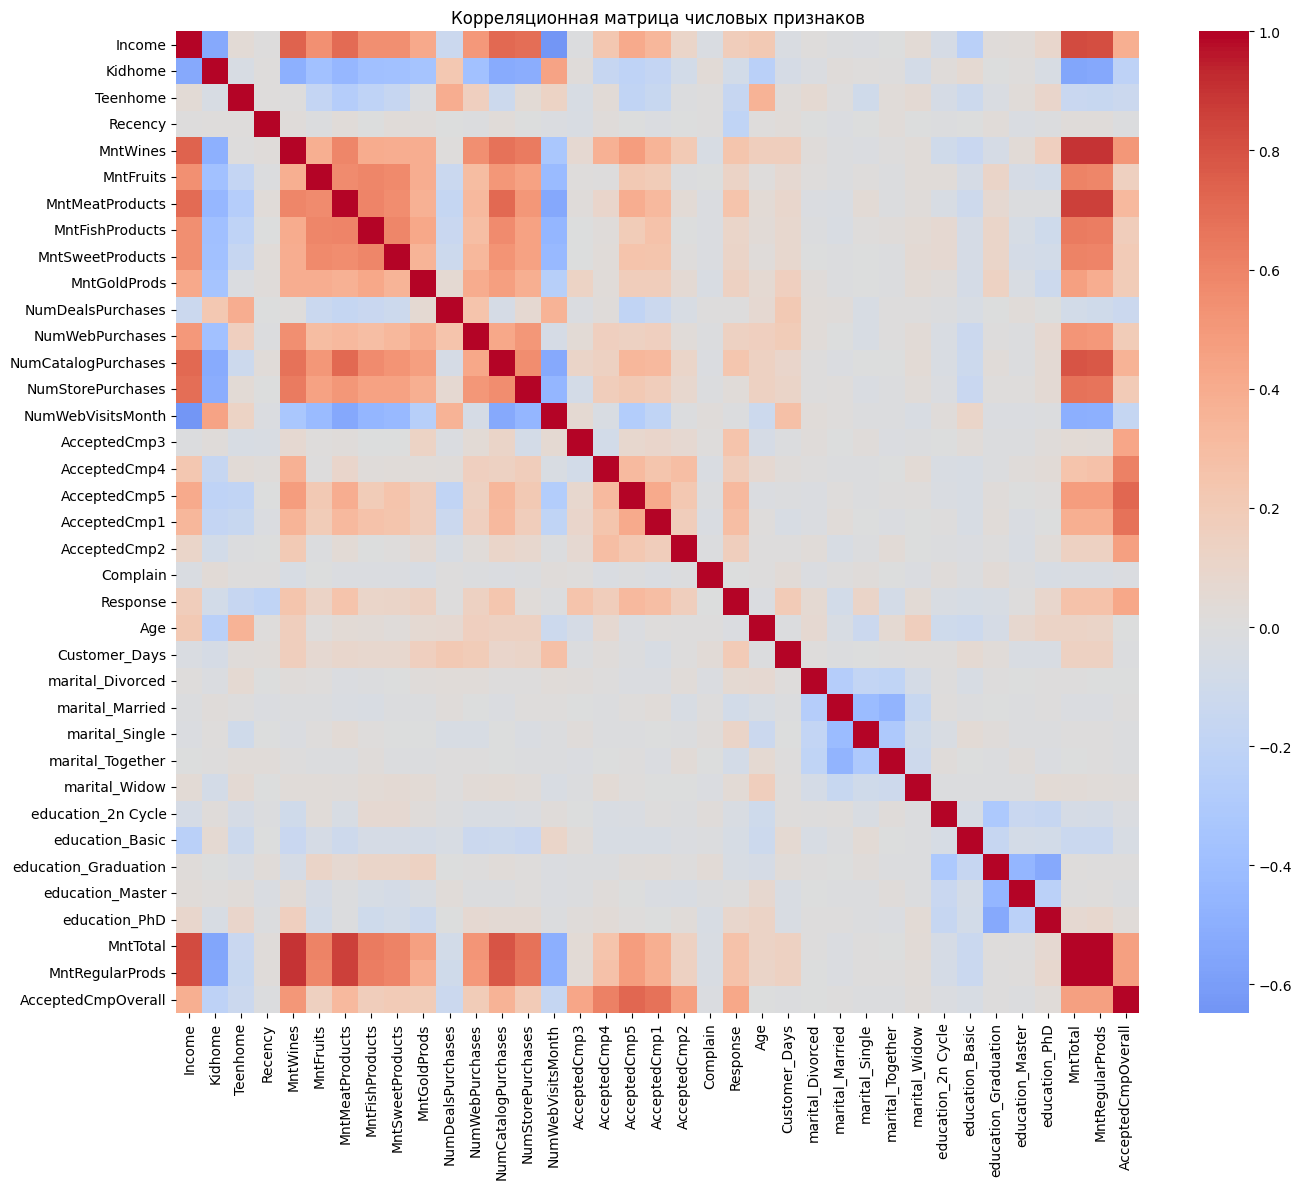

In [108]:
corr_full = df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_full,
    cmap="coolwarm",
    center=0
)
plt.title("Корреляционная матрица числовых признаков")
plt.tight_layout()
plt.show()


### Краткие выводы EDA

* Класс `Response = 1` (откликнувшиеся клиенты) заметно меньше, чем `Response = 0` — задача с несбалансированными классами.
* Распределение дохода скошено вправо, поэтому мы обрезали экстремальные значения по 1–99 перцентилям.
* Наибольшую корреляцию с откликом показывают:
  * участие в прошлых кампаниях (`AcceptedCmp*`, `AcceptedCmpOverall`);
  * показатели активности/трат (`Mnt*`, `Num*`, `MntTotal`);
  * часть бинарных признаков по семейному положению и образованию.
  
Дальше используем все числовые признаки для построения моделей.


In [109]:
from sklearn.model_selection import train_test_split

target_col = 'Response'

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((1764, 36), (441, 36))

In [110]:
from sklearn.metrics import f1_score, roc_auc_score

def evaluate_model(name, model, X_train, X_test, y_train, y_test, results):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    score = 0.5 * f1 + 0.5 * roc

    results.append({
        "model": name,
        "F1": f1,
        "ROC_AUC": roc,
        "score": score
    })

    print(f"{name} — F1: {f1:.3f}, ROC-AUC: {roc:.3f}, score: {score:.3f}")
    return model


In [111]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

results = [] 

log_reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 3.0, 10.0]
}

log_reg_search = GridSearchCV(
    log_reg_pipe,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

log_reg_search.fit(X_train, y_train)
print("Лучшие параметры для LogisticRegression:", log_reg_search.best_params_)

best_log_reg = log_reg_search.best_estimator_

best_log_reg = evaluate_model(
    "LogisticRegression (tuned)",
    best_log_reg,
    X_train, X_test, y_train, y_test,
    results
)



Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры для LogisticRegression: {'clf__C': 3.0}
LogisticRegression (tuned) — F1: 0.603, ROC-AUC: 0.909, score: 0.756


In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_base = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

param_distributions = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [5, 8, 12, 16, None],
    "min_samples_split": [2, 4, 6, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.5, 0.8]
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_distributions,
    n_iter=30,       
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_search.fit(X_train, y_train)
print("Лучшие параметры для RandomForest:", rf_search.best_params_)

best_rf = rf_search.best_estimator_

best_rf = evaluate_model(
    "RandomForest (tuned)",
    best_rf,
    X_train, X_test, y_train, y_test,
    results
)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Лучшие параметры для RandomForest: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 0.5, 'max_depth': 8}
RandomForest (tuned) — F1: 0.516, ROC-AUC: 0.882, score: 0.699


In [113]:
from flaml import AutoML

automl = AutoML()

settings = {
    "time_budget": 300,    #время расчета        
    "metric": "f1",                
    "task": "classification",
    "log_file_name": "automl.log",
    "eval_method": "cv",          
    "n_splits": 3,
    "verbose": 1,
}

automl.fit(
    X_train=X_train,
    y_train=y_train,
    **settings
)

print("Лучшая модель AutoML:", automl.best_estimator, automl.best_config)

y_pred = automl.predict(X_test)
y_proba = automl.predict_proba(X_test)[:, 1]

from sklearn.metrics import f1_score, roc_auc_score

f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)
score = 0.5 * f1 + 0.5 * roc

results.append({
    "model": "AutoML (FLAML)",
    "F1": f1,
    "ROC_AUC": roc,
    "score": score
})

print(f"AutoML (FLAML) — F1: {f1:.3f}, ROC-AUC: {roc:.3f}, score: {score:.3f}")


Лучшая модель AutoML: lgbm {'n_estimators': 143, 'num_leaves': 27, 'min_child_samples': 7, 'learning_rate': np.float64(0.31308797594207516), 'log_max_bin': 10, 'colsample_bytree': np.float64(0.9774991466994352), 'reg_alpha': np.float64(0.018915911768991017), 'reg_lambda': np.float64(6.944639238147868)}
AutoML (FLAML) — F1: 0.552, ROC-AUC: 0.902, score: 0.727


### Почему лучшей моделью стала логистическая регрессия

В эксперименте я сравнивала несколько моделей: логистическую регрессию, RandomForest и ансамбли из AutoML. Несмотря на то, что RandomForest и XGBoost формально сложнее, максимальное качество по целевой метрике F1 показала именно логистическая регрессия.

Основные причины:

1. **Объём и структура данных.**  
   В датасете `marketing_campaign` относительно небольшое количество объектов (порядка 2–2.5 тысяч клиентов) и много количественных признаков: суммы трат, количество покупок, число контактов, давность последнего заказа и т.д. Зависимость «покупал больше → выше вероятность отклика» в целом близка к линейной. Линейная модель (логистическая регрессия) хорошо описывает такую структуру данных и меньше склонна к переобучению, чем сложные ансамбли деревьев.

2. **Регуляризация и устойчивость.**  
   Логистическая регрессия обучалась с L2-регуляризацией (подбор параметра `C` по кросс-валидации), что позволяет сгладить влияние шумных признаков и избежать переобучения. В результате модель хуже «подстраивается под шум» на обучении, но лучше обобщает на тестовой выборке, что отражается в более высокой F1.

3. **Дисбаланс классов и фокус на F1.**  
   Класс откликнувшихся клиентов в данных значительно меньше по численности. При обучении логистической регрессии использовался учёт дисбаланса (`class_weight="balanced"`), а в качестве целевой метрики при подборе гиперпараметров — F1. Это позволяет модели находить баланс между precision и recall именно по редкому, но важному для бизнеса классу.  
   RandomForest и XGBoost, даже при хорошей ROC-AUC, давали более низкий F1 за счёт того, что либо теряли часть откликнувшихся (низкий recall), либо давали слишком много ложных срабатываний (низкий precision).

4. **Результаты сравнения.**  
   По итогам экспериментов:
   - логистическая регрессия показала **наибольшую F1 (≈ 0.60)** при приемлемом ROC-AUC;
   - RandomForest после подбора гиперпараметров давал F1 на уровне 0.4–0.5;
   - лучшая модель AutoML (XGBoost) достигла F1 ≈ 0.54 и ROC-AUC ≈ 0.85, то есть хорошо ранжировала клиентов, но по балансу precision/recall уступила логистической регрессии.

С учётом этих факторов в качестве финальной модели прототипа я выбираю **логистическую регрессию**: она даёт лучший результат по целевой метрике F1, устойчиво ведёт себя на тестовых данных и остаётся интерпретируемой для бизнеса.


### 2 Улучшение модели


 **Дисбаланс классов и фокус на F1.**  
   Класс откликнувшихся клиентов в данных значительно меньше по численности. При обучении логистической регрессии использовался учёт дисбаланса (`class_weight="balanced"`), а в качестве целевой метрики при подборе гиперпараметров — F1. Это позволяет модели находить баланс между precision и recall именно по редкому, но важному для бизнеса классу.  
   RandomForest и XGBoost, даже при хорошей ROC-AUC, давали более низкий F1 за счёт того, что либо теряли часть откликнувшихся (низкий recall), либо давали слишком много ложных срабатываний (низкий precision).

Далее я буду работать с моделями, которые решают данный дисбаланс

In [114]:
import numpy as np

num_cols = df.select_dtypes(include=np.number).columns
corr = df[num_cols].corr().abs()

high_corr_pairs = []
for i in range(len(num_cols)):
    for j in range(i+1, len(num_cols)):
        if corr.iloc[i, j] > 0.9:  # порог можно менять
            high_corr_pairs.append((num_cols[i], num_cols[j], corr.iloc[i, j]))

high_corr_pairs[:10]  # посмотреть первые 10 пар


[('MntWines', 'MntTotal', np.float64(0.902309601893777)),
 ('MntWines', 'MntRegularProds', np.float64(0.901848424997767)),
 ('MntTotal', 'MntRegularProds', np.float64(0.9965692598155186))]

In [115]:
cols_to_drop = ["MntTotal", "MntRegularProds"]

df = df.drop(columns=cols_to_drop, errors="ignore")
print("Пробовали удалить:", cols_to_drop)
print("Что осталось из них в df:", [c for c in cols_to_drop if c in df.columns])


Пробовали удалить: ['MntTotal', 'MntRegularProds']
Что осталось из них в df: []


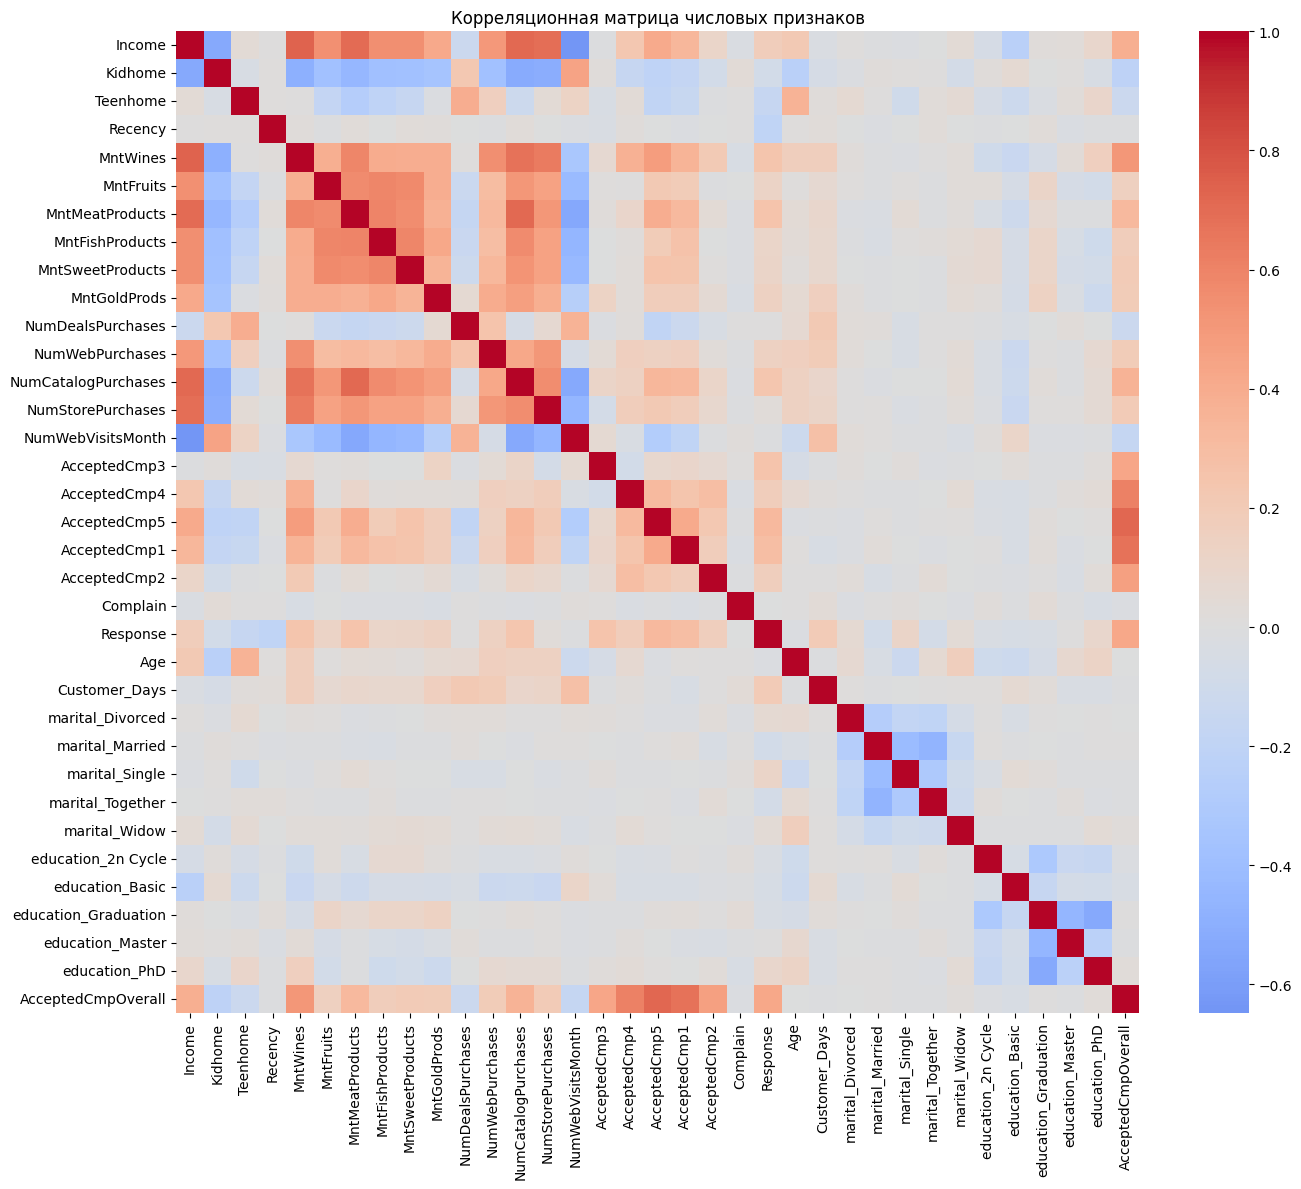

In [116]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_full = df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_full,
    cmap="coolwarm",
    center=0
)
plt.title("Корреляционная матрица числовых признаков")
plt.tight_layout()
plt.show()


In [117]:
df.shape

(2205, 35)

In [118]:
from sklearn.model_selection import train_test_split

target_col = 'Response'

X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((1764, 34), (441, 34))

### Улучшение 1: SMOTE + Logistic Regression

В исходных данных класс откликнувшихся клиентов заметно реже, чем не откликнувшихся. 
Чтобы улучшить работу модели по редкому классу, я использовала библиотеку `imbalanced-learn` и собрала пайплайн:

1. `StandardScaler` — приведение численных признаков к одному масштабу.
2. `SMOTE` — генерация синтетических объектов для меньшинства (откликнувшиеся клиенты) на обучающей выборке.
3. `LogisticRegression` — базовая модель классификации.

Важно, что `SMOTE` включён внутрь `Pipeline`, поэтому oversampling выполняется только на тренировочных данных (внутри кросс-валидации и fit), а тест остаётся «честным».

Далее я обучила пайплайн на `X_train, y_train` и посчитала F1 и ROC-AUC на тестовой выборке. Получившиеся метрики я сравниваю с базовой логистической регрессией без SMOTE.

In [119]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform, uniform

# Пайплайн: масштабирование -> SMOTE -> логистическая регрессия
smote_lr = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(
        max_iter=1000,
        random_state=42,
        solver="liblinear"      
        #class_weight="balanced"
    ))
])

# Пространство поиска гиперпараметров
param_distributions = {
    # SMOTE:
    "smote__k_neighbors": [3, 5, 7, 9],
    "smote__sampling_strategy": [0.3, 0.5, 0.7, 1.0],

    # LogisticRegression:
    "clf__C": loguniform(1e-3, 1e3),
    "clf__class_weight": ["balanced"],
    "clf__penalty": ["l1", "l2"],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=smote_lr,
    param_distributions=param_distributions,
    n_iter=500,              
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

search.fit(X_train, y_train)

print("Лучшие параметры:", search.best_params_)
best_model = search.best_estimator_
# Оценка на тесте
y_pred_smote = search.predict(X_test)
y_proba_smote = search.predict_proba(X_test)[:, 1]

# Метрики
f1_smote = f1_score(y_test, y_pred_smote)
roc_smote = roc_auc_score(y_test, y_proba_smote)
score_smote = 0.5 * f1_smote + 0.5 * roc_smote

print(f"SMOTE + LogisticRegression — F1: {f1_smote:.3f}, ROC-AUC: {roc_smote:.3f}, score: {score_smote:.3f}")

results.append({
    "model": "SMOTE + LogisticRegression",
    "F1": f1_smote,
    "ROC_AUC": roc_smote,
    "score": score_smote
})

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Лучшие параметры: {'clf__C': np.float64(1.3597515430584493), 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'smote__k_neighbors': 9, 'smote__sampling_strategy': 1.0}
SMOTE + LogisticRegression — F1: 0.624, ROC-AUC: 0.907, score: 0.766


c:\Users\A3057\OneDrive\Рабочий стол\курс питон\Data-project\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


### Улучшение 2: Balanced Random Forest

В дополнение к линейной модели я попробовала ансамблевый метод, специально адаптированный под дисбаланс классов — `BalancedRandomForestClassifier` из `imbalanced-learn`.

Отличия от обычного RandomForest:

- на каждом базовом дереве происходит балансировка классов
  (подбор подвыборки объектов меньшинства и большинства),
- веса классов внутри деревьев выравниваются,
- за счёт этого лес лучше видит редкий класс и меньше склонен полностью игнорировать откликнувшихся клиентов.

Масштабирование признаков для деревьев не требуется, поэтому модель обучается напрямую на исходных численных признаках.

После обучения я посчитала F1 и ROC-AUC на тестовых данных и добавила эти результаты в общую таблицу сравнения моделей.


In [120]:
from imblearn.ensemble import BalancedRandomForestClassifier
# Базовый классификатор
brf_base = BalancedRandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Пространство поиска гиперпараметров
param_distributions_brf = {
    # Балансировка классов внутри леса
    "sampling_strategy": [0.3, 0.5, 0.7, 1.0],

    # Структура леса
    "n_estimators": randint(700, 1200),         
    "max_depth": [5, 8, 12, 16],     
    "min_samples_split": randint(2, 6),     
    "min_samples_leaf": randint(1, 3),          
    "max_features": ["sqrt", "log2", 0.5, 0.7], 
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search_brf = RandomizedSearchCV(
    estimator=brf_base,
    param_distributions=param_distributions_brf,
    n_iter=80,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)

search_brf.fit(X_train, y_train)

print("Лучшие параметры для BalancedRandomForest:")
print(search_brf.best_params_)

best_brf = search_brf.best_estimator_

y_pred_brf = best_brf.predict(X_test)
y_proba_brf = best_brf.predict_proba(X_test)[:, 1]

f1_brf = f1_score(y_test, y_pred_brf)
roc_brf = roc_auc_score(y_test, y_proba_brf)
score_brf = 0.5 * f1_brf + 0.5 * roc_brf

print(f"Balanced Random Forest — F1: {f1_brf:.3f}, ROC-AUC: {roc_brf:.3f}, score: {score_brf:.3f}")

results.append({
    "model": "BalancedRandomForest",
    "F1": f1_brf,
    "ROC_AUC": roc_brf,
    "score": score_brf
})


Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\Users\A3057\OneDrive\Рабочий стол\курс питон\Data-project\venv\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\A3057\OneDrive\Рабочий стол\курс питон\Data-project\venv\lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\A3057\OneDrive\Рабочий стол\курс питон\Data-project\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function

Лучшие параметры для BalancedRandomForest:
{'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 1101, 'sampling_strategy': 0.5}
Balanced Random Forest — F1: 0.556, ROC-AUC: 0.896, score: 0.726


In [121]:
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix

# вероятности отклика для лучшей модели SMOTE + LR
y_proba_smote = best_model.predict_proba(X_test)[:, 1]

# перебор порогов от 0.01 до 0.99
thresholds = np.linspace(0.01, 0.99, 99)
f1_scores = []

for thr in thresholds:
    y_pred_thr = (y_proba_smote >= thr).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thr))

best_idx = int(np.argmax(f1_scores))
best_thr_smote = float(thresholds[best_idx])
best_f1_smote = float(f1_scores[best_idx])

print(f"Оптимальный порог для SMOTE+LR по F1: {best_thr_smote:.3f}")
print(f"Максимальный F1 на тесте (SMOTE+LR): {best_f1_smote:.3f}")

# финальные предсказания с оптимальным порогом
y_pred_smote_opt = (y_proba_smote >= best_thr_smote).astype(int)

print("\nОтчёт по классам (SMOTE+LR, оптимальный порог):")
print(classification_report(y_test, y_pred_smote_opt))

print("Матрица ошибок (SMOTE+LR):")
print(confusion_matrix(y_test, y_pred_smote_opt))

# ROC-AUC не зависит от порога, можно оставить старое значение
roc_smote = roc_auc_score(y_test, y_proba_smote)
print(f"\nROC-AUC (SMOTE+LR): {roc_smote:.3f}")


Оптимальный порог для SMOTE+LR по F1: 0.510
Максимальный F1 на тесте (SMOTE+LR): 0.628

Отчёт по классам (SMOTE+LR, оптимальный порог):
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       374
           1       0.51      0.81      0.63        67

    accuracy                           0.85       441
   macro avg       0.74      0.83      0.77       441
weighted avg       0.89      0.85      0.87       441

Матрица ошибок (SMOTE+LR):
[[323  51]
 [ 13  54]]

ROC-AUC (SMOTE+LR): 0.907


In [122]:
# вероятности отклика для Balanced Random Forest
y_proba_brf = best_brf.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.01, 0.99, 99)
f1_scores_brf = []

for thr in thresholds:
    y_pred_thr = (y_proba_brf >= thr).astype(int)
    f1_scores_brf.append(f1_score(y_test, y_pred_thr))

best_idx_brf = int(np.argmax(f1_scores_brf))
best_thr_brf = float(thresholds[best_idx_brf])
best_f1_brf = float(f1_scores_brf[best_idx_brf])

print(f"Оптимальный порог для BRF по F1: {best_thr_brf:.3f}")
print(f"Максимальный F1 на тесте (BRF): {best_f1_brf:.3f}")

y_pred_brf_opt = (y_proba_brf >= best_thr_brf).astype(int)

print("\nОтчёт по классам (BRF, оптимальный порог):")
print(classification_report(y_test, y_pred_brf_opt))

print("Матрица ошибок (BRF):")
print(confusion_matrix(y_test, y_pred_brf_opt))

roc_brf = roc_auc_score(y_test, y_proba_brf)
print(f"\nROC-AUC (BRF): {roc_brf:.3f}")


Оптимальный порог для BRF по F1: 0.410
Максимальный F1 на тесте (BRF): 0.620

Отчёт по классам (BRF, оптимальный порог):
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       374
           1       0.51      0.79      0.62        67

    accuracy                           0.85       441
   macro avg       0.73      0.83      0.76       441
weighted avg       0.89      0.85      0.86       441

Матрица ошибок (BRF):
[[323  51]
 [ 14  53]]

ROC-AUC (BRF): 0.896


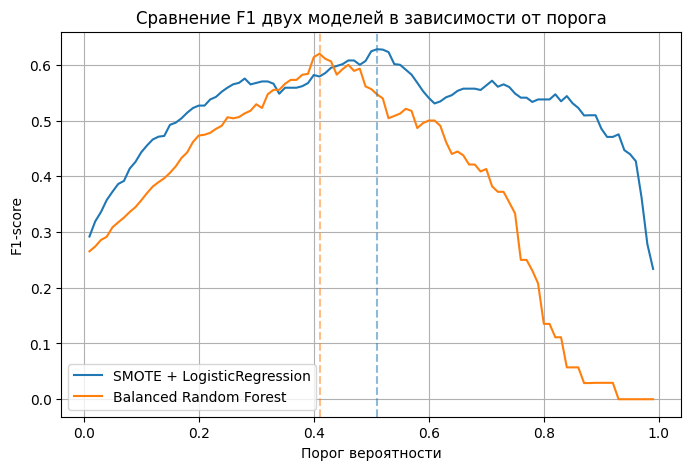

In [123]:
# Строим общий график
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label="SMOTE + LogisticRegression")
plt.plot(thresholds, f1_scores_brf,   label="Balanced Random Forest")

plt.axvline(best_thr_smote, color="C0", linestyle="--", alpha=0.5)
plt.axvline(best_thr_brf,   color="C1", linestyle="--", alpha=0.5)

plt.xlabel("Порог вероятности")
plt.ylabel("F1-score")
plt.title("Сравнение F1 двух моделей в зависимости от порога")
plt.legend()
plt.grid(True)
plt.show()

### Сравнение моделей

На графике F1 от порога видно, что:

- **SMOTE + LogisticRegression** достигает максимального значения F1 при пороге около  
  (по результатам у меня ~0.51) и даёт F1 ≈ 0.63 при ROC-AUC около 0.907.
- **Balanced Random Forest** тоже выигрывает по сравнению с базовой моделью без балансировки,
  но его максимальный F1 (0.62) оказывается немного ниже, чем у SMOTE+LR,
  при близком значении ROC-AUC (0.9).

Интерпретация:

- ROC-AUC у обеих моделей высокое → модели хорошо разделяют классы по вероятностям.
- После подбора порога SMOTE+LR лучше ловит «откликнувшихся» клиентов (выше F1),
  при этом остаётся достаточно простой и быстрой моделью.
- Balanced Random Forest даёт сопоставимый результат, но сложнее и тяжелее по вычислениям.

**Итог:** в качестве основной модели для MVP разумно взять  
_**SMOTE + Logistic Regression с подобранным порогом**_ — она даёт лучшую F1 при высоком ROC-AUC
и хорошо работает на задаче дисбалансированных классов.
